# Tennis - MADDPG ( Training )

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Reacher.app"`
- **Windows** (x86): `"path/to/Reacher_Windows_x86/Reacher.exe"`
- **Windows** (x86_64): `"path/to/Reacher_Windows_x86_64/Reacher.exe"`
- **Linux** (x86): `"path/to/Reacher_Linux/Reacher.x86"`
- **Linux** (x86_64): `"path/to/Reacher_Linux/Reacher.x86_64"`
- **Linux** (x86, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86"`
- **Linux** (x86_64, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86_64"`

For instance, if you are using a Mac, then you downloaded `Reacher.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Reacher.app")
```

In [2]:
env = UnityEnvironment(file_name="Tennis")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Of course, as part of the project, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

In [5]:
# env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
# states = env_info.vector_observations                  # get the current state (for each agent)
# scores = np.zeros(num_agents)                          # initialize the score (for each agent)
# while True:
#     actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
#     actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
#     env_info = env.step(actions)[brain_name]           # send all actions to tne environment
#     next_states = env_info.vector_observations         # get next state (for each agent)
#     rewards = env_info.rewards                         # get reward (for each agent)
#     dones = env_info.local_done                        # see if episode finished
#     scores += env_info.rewards                         # update the score (for each agent)
#     states = next_states                               # roll over states to next time step
#     if np.any(dones):                                  # exit loop if episode finished
#         break
# print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

When finished, you can close the environment.

### 4. It's MY Turn!

### Importing Usual Stuff

In [6]:
import gym

import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt

import pickle

import seaborn as sns
from IPython.display import clear_output

sns.set(style='whitegrid', context='notebook', palette='icefire')

%matplotlib inline

### Default Tensor Processing Device

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Plotting Helper

In [9]:
def plot(episode_n, rewards1, rewards2, N = 100):
  clear_output(True)
  plt.figure(figsize=(20, 5))
  plt.subplot(111)
  plt.title('Episode %s. reward: %s' % (episode_n, rewards1[-1]))
  
  plt.axhline(y=0.5, color='gold', linestyle='-.', label="Solved")
  plt.plot(rewards1)
  plt.plot(rewards2)
  
  if len(rewards1)>110:
    moving_average = np.convolve(rewards1, np.ones((N,))/N, mode='valid')
    plt.plot(range(int(N/2), len(moving_average)+int(N/2)), moving_average, color='red', label="Moving Average 1" )

  if len(rewards2)>110:
    moving_average = np.convolve(rewards2, np.ones((N,))/N, mode='valid')
    plt.plot(range(int(N/2), len(moving_average)+int(N/2)), moving_average, color='green', label="Moving Average 2" )
  
  plt.show()

### Define Brains and Solver Networks

In [10]:
from brains import MADDPGActor, MADDPGCentralCriticNetwork
from agents import TwoAgentMADDPGSolver, DDPQAgent

In [11]:
blueBrain = MADDPGActor(hidden_sizes=[128, 128]).to(device)
redBrain  = MADDPGActor(hidden_sizes=[128, 128]).to(device)

blueBrain_target = MADDPGActor(hidden_sizes=[128, 128]).to(device)
redBrain_target  = MADDPGActor(hidden_sizes=[128, 128]).to(device)

blueCritic = MADDPGCentralCriticNetwork(hidden_sizes=[128, 128]).to(device)
redCritic  = MADDPGCentralCriticNetwork(hidden_sizes=[128, 128]).to(device)

blueCritic_target = MADDPGCentralCriticNetwork(hidden_sizes=[128, 128]).to(device)
redCritic_target  = MADDPGCentralCriticNetwork(hidden_sizes=[128, 128]).to(device)

In [12]:
blueAgent = DDPQAgent(actor_network_local=blueBrain, actor_network_target=blueBrain_target, critic_network_local=blueCritic, critic_network_target=blueCritic_target)

redAgent = DDPQAgent(actor_network_local=redBrain, actor_network_target=redBrain_target, critic_network_local=redCritic, critic_network_target=redCritic_target)

In [13]:
solver = TwoAgentMADDPGSolver(Agent1=blueAgent, Agent2=redAgent)

### Let's Solve!

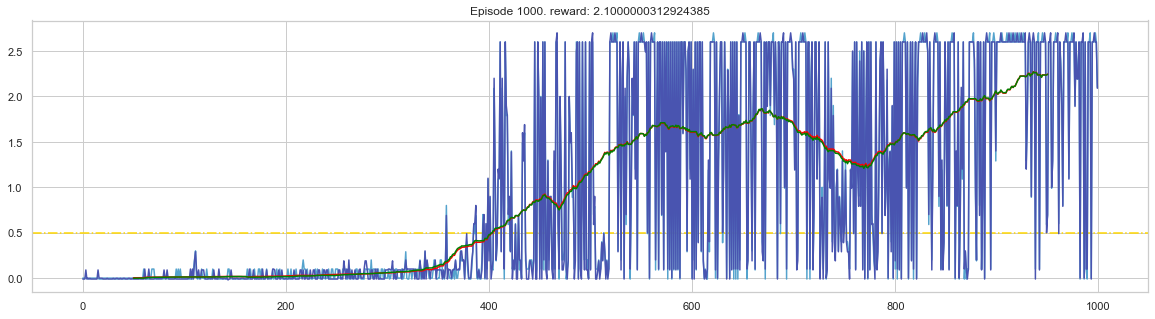

Episode 1000	Average Score: 2.26

In [15]:
n_episodes = 1_000
eps_start  = 1.0
eps_end    = 0.01
eps_decay  = 0.9995

scores1 = []
scores2 = []

scores_window = deque(maxlen=100)                               # last 100 scores

for i_episode in range(1, n_episodes+1):
  fast_or_slow = True #if i_episode<500 else False
  env_info = env.reset(train_mode=fast_or_slow)[brain_name]     # reset the environment
  
  states = env_info.vector_observations
  scores = np.zeros(2)

  while True:
    actions = solver.act(states, True)
    env_info = env.step(actions)[brain_name]                    # send the action to the environment
    
    next_states = env_info.vector_observations
    rewards = env_info.rewards
    rMax = max(rewards)
    done    = env_info.local_done
    
    solver.step(states, actions, rewards, next_states, done)    # UPDATE THE NETWORK
    
    states = next_states 
    scores += rewards
    
    if np.any(done):                                # Reset if Done
      break
  
  scores_window.append(max(scores))                 # save most recent score
  scores1.append(scores[0])                         # save most recent score
  scores2.append(scores[1])                         # save most recent score
  plot(i_episode, scores1, scores2)

  print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")

### Save the Scores

In [17]:
with open('1000-RunScores1-4.pkl', 'wb') as f:
  pickle.dump(scores1, f)
  
with open('1000-RunScores2-4pkl', 'wb') as f:
  pickle.dump(scores2, f)

### Save the Brains

In [18]:
torch.save(blueBrain.state_dict(), 'blueActor_brain.pth')
torch.save(redBrain.state_dict(), 'redActor_brain.pth')

torch.save(blueCritic.state_dict(), 'blueCritic_brain.pth')
torch.save(redCritic.state_dict(), 'redCritic_brain.pth')